### Upload data to colab

In [1]:
# from google.colab import files
# uploaded = files.upload()  # upload features_3_sec.csv

### Import Library

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch.nn as nn
np.random.seed(42)

### Data read in & Preprocess

In [3]:
df = pd.read_csv("features_30_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
df=df.drop(labels="filename",axis=1)

In [5]:
class_list=df.iloc[:,-1]
converter=LabelEncoder()
y=converter.fit_transform(class_list)

In [6]:
print(df.iloc[:,:-1])

     length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0    661794          0.350088         0.088757  0.130228  0.002827   
1    661794          0.340914         0.094980  0.095948  0.002373   
2    661794          0.363637         0.085275  0.175570  0.002746   
3    661794          0.404785         0.093999  0.141093  0.006346   
4    661794          0.308526         0.087841  0.091529  0.002303   
..      ...               ...              ...       ...       ...   
995  661794          0.352063         0.080487  0.079486  0.000345   
996  661794          0.398687         0.075086  0.076458  0.000588   
997  661794          0.432142         0.075268  0.081651  0.000322   
998  661794          0.362485         0.091506  0.083860  0.001211   
999  661794          0.358401         0.085884  0.054454  0.000336   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               1784.165850          129774.064525              2002.449060   
1

In [7]:
fit=StandardScaler()
X=fit.fit_transform(np.array(df.iloc[:,:-1],dtype=float))

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)

In [9]:
unique_elements, counts = np.unique(y_train, return_counts=True)
proportions = counts / len(y_train)

for element, proportion in zip(unique_elements, proportions):
    # round to 2 decimal places and convert to percentage
    proportion = round(proportion * 100, 2)
    print(f"Label {element}: Proportion {proportion}%")


Label 0: Proportion 9.67%
Label 1: Proportion 10.44%
Label 2: Proportion 9.67%
Label 3: Proportion 10.0%
Label 4: Proportion 10.44%
Label 5: Proportion 9.67%
Label 6: Proportion 9.67%
Label 7: Proportion 10.22%
Label 8: Proportion 10.11%
Label 9: Proportion 10.11%


### Build the model

In [10]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.2):
        super(MyModel, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_sizes = [input_size] + hidden_sizes
        for i in range(1, len(self.hidden_sizes)):
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]),
                nn.ReLU(),
                nn.Dropout(dropout_prob)
            ))
        self.output_layer = nn.Linear(self.hidden_sizes[-1], output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x


input_size = X_train.shape[1]
hidden_sizes = [1024, 512, 256, 128]
output_size = 10
dropout_prob = 0.3

model = MyModel(input_size, hidden_sizes, output_size, dropout_prob)


In [11]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Check if GPU is available
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"

device = torch.device(dev)

# Move your network and any necessary inputs to the GPU
model = model.to(device)


# Convert the training data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_loss_log = []
val_loss_log = []

patience = 40  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss
patience_counter = 0  # Counter to keep track of the number of epochs without improvement

# Train the model
num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        accuracy = torch.sum(torch.argmax(y_pred, dim=1) == y_train_tensor).item() / len(y_train_tensor)
        val_accuracy = torch.sum(torch.argmax(model(X_test_tensor), dim=1) == y_test_tensor.to(device)).item() / len(y_test)
        val_loss = criterion(model(torch.tensor(X_test, dtype=torch.float32).to(device)), torch.tensor(y_test, dtype=torch.long).to(device))
        train_loss_log.append(loss.item())
        val_loss_log.append(val_loss.item())
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Accuracy: {accuracy}, Val loss: {val_loss.item()}, Val Accuracy: {val_accuracy}")

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print("Early stopping")
                break

Epoch 10, Loss: 2.1083619594573975, Accuracy: 0.35333333333333333, Val loss: 2.1499929428100586, Val Accuracy: 0.29
Epoch 20, Loss: 1.9875868558883667, Accuracy: 0.49, Val loss: 2.0627832412719727, Val Accuracy: 0.46
Epoch 30, Loss: 1.8873846530914307, Accuracy: 0.5711111111111111, Val loss: 1.9477735757827759, Val Accuracy: 0.54
Epoch 40, Loss: 1.8050358295440674, Accuracy: 0.6511111111111111, Val loss: 1.9025524854660034, Val Accuracy: 0.57
Epoch 50, Loss: 1.7442213296890259, Accuracy: 0.7255555555555555, Val loss: 1.8139293193817139, Val Accuracy: 0.55
Epoch 60, Loss: 1.6953692436218262, Accuracy: 0.7766666666666666, Val loss: 1.839776873588562, Val Accuracy: 0.65
Epoch 70, Loss: 1.6490107774734497, Accuracy: 0.82, Val loss: 1.8162446022033691, Val Accuracy: 0.65
Epoch 80, Loss: 1.6184765100479126, Accuracy: 0.8477777777777777, Val loss: 1.7819689512252808, Val Accuracy: 0.69
Epoch 90, Loss: 1.5988707542419434, Accuracy: 0.8722222222222222, Val loss: 1.798317313194275, Val Accuracy:

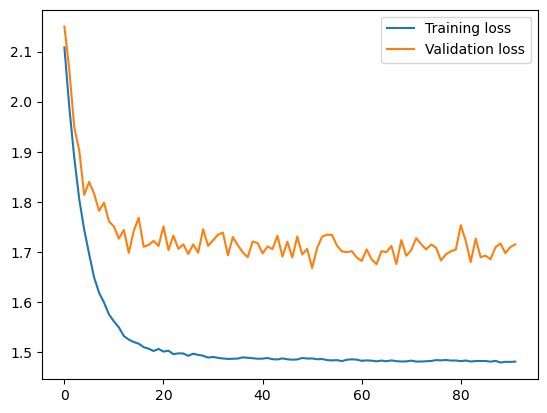

In [12]:
# plot the training and validation loss
plt.plot(train_loss_log, label='Training loss')
plt.plot(val_loss_log, label='Validation loss')
plt.legend()
plt.show()

### Evaluation

In [13]:
# 4 metrics to measure the performance in test set
print(classification_report(y_test_tensor.detach().cpu().numpy(), torch.argmax(model(X_test_tensor), dim=1).detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       1.00      1.00      1.00         6
           2       0.69      0.69      0.69        13
           3       0.73      0.80      0.76        10
           4       0.83      0.83      0.83         6
           5       0.79      0.85      0.81        13
           6       0.92      0.92      0.92        13
           7       0.71      0.62      0.67         8
           8       0.62      0.56      0.59         9
           9       0.50      0.56      0.53         9

    accuracy                           0.74       100
   macro avg       0.75      0.74      0.74       100
weighted avg       0.74      0.74      0.74       100

